# Reinforcement Learning - Task 02

In [8]:
import numpy as np 
import random
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import seaborn as sns 

### 1. Defining the Environment in a Matrix Structure

In [2]:
maze = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,1,0,1,1,1,1,1,1,0],
    [0,1,1,1,0,1,1,0,1,0],
    [0,0,0,1,0,1,0,0,1,0],
    [0,1,1,1,1,1,1,1,1,0],
    [0,1,0,1,0,0,0,0,0,0],
    [0,1,0,1,0,1,1,1,1,0],
    [0,1,0,0,0,1,0,0,1,0],
    [0,1,1,1,1,1,1,0,1,0],
    [0,0,0,0,0,0,0,0,0,0]
])

start = (1,1)
goal = (8,8)


### 2. Plotting the Maze

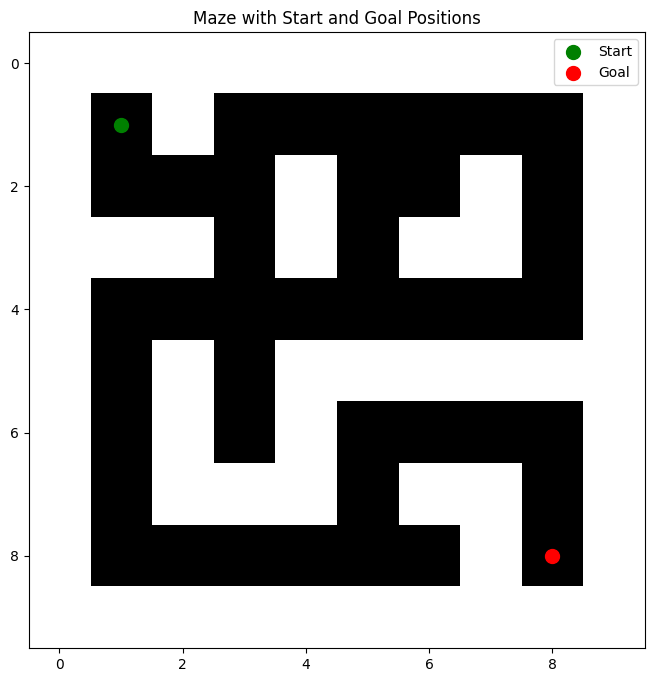

In [3]:
# Plot the maze
plt.figure(figsize=(8, 8))
plt.imshow(maze, cmap='gray_r')  # 'gray_r' makes 1s white and 0s black

plt.scatter(start[1], start[0], color='green', s=100, label="Start")
plt.scatter(goal[1], goal[0], color='red', s=100, label="Goal")

plt.title("Maze with Start and Goal Positions")
plt.legend()
plt.show()

### 3. Initialize Q-Table with Random Values

In [4]:
actions = ['up', 'down', 'left', 'right']

Q = np.random.uniform(low=-1, high=1, size=(maze.shape[0], maze.shape[1], len(actions)))

#hyperparameters 
alpha= 0.1
gamma = 0.9
epsilon = 0.6
epochs = 500

### 4. Training and Evaluation

In [7]:
def get_next_position(position, action):
    x, y = position
    if action == 'up' and x > 0 and maze[x - 1, y] == 1: x -= 1
    elif action == 'down' and x < maze.shape[0] - 1 and maze[x + 1, y] == 1: x += 1
    elif action == 'left' and y > 0 and maze[x, y - 1] == 1: y -= 1
    elif action == 'right' and y < maze.shape[1] - 1 and maze[x, y + 1] == 1: y += 1
    return (x, y)


#### Model Training and Evaluation

In [9]:
def visualize_state_visits(state_visits):
    """
    Visualizes the heatmap of state visits during training.
    """
    plt.figure(figsize=(8, 8))
    sns.heatmap(state_visits, annot=False, cmap='coolwarm', cbar=True)
    plt.title("Heatmap of State Visits During Training")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

In [10]:

def plot_policy_with_qvalues(epoch):
    """
    Visualizes the policy with Q-values for the current epoch.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(maze, cmap='gray_r')  # Plot the maze
    plt.grid(visible=True, color='white', linestyle='-', linewidth=1)  # Gridlines
    plt.xticks(np.arange(-0.5, maze.shape[1], 1), [])  # Set x-ticks
    plt.yticks(np.arange(-0.5, maze.shape[0], 1), [])  # Set y-ticks
    plt.gca().set_xticks(np.arange(-0.5, maze.shape[1], 1), minor=True)  # Minor gridlines
    plt.gca().set_yticks(np.arange(-0.5, maze.shape[0], 1), minor=True)
    plt.grid(which="minor", color="black", linestyle='-', linewidth=1)
    plt.tick_params(which='both', bottom=False, left=False)  # Remove axis ticks

    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:  # Walkable position
                # Get the Q-values for all actions
                q_values = Q[i, j, :]
                best_action_index = np.argmax(q_values)
                best_action = actions[best_action_index]

                # Plot the Q-values at respective positions
                plt.text(j, i - 0.3, f"{q_values[0]:.2f}", fontsize=6, ha='center', color='yellow')  # Up
                plt.text(j, i + 0.3, f"{q_values[1]:.2f}", fontsize=6, ha='center', color='yellow')  # Down
                plt.text(j - 0.3, i, f"{q_values[2]:.2f}", fontsize=6, ha='center', color='yellow')  # Left
                plt.text(j + 0.3, i, f"{q_values[3]:.2f}", fontsize=6, ha='center', color='yellow')  # Right

                # Display the best action as an arrow
                if best_action == 'up':
                    plt.arrow(j, i, 0, -0.1, head_width=0.1, head_length=0.1, fc='red', ec='red')
                elif best_action == 'down':
                    plt.arrow(j, i, 0, 0.1, head_width=0.1, head_length=0.1, fc='red', ec='red')
                elif best_action == 'left':
                    plt.arrow(j, i, -0.1, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')
                elif best_action == 'right':
                    plt.arrow(j, i, 0.1, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')

    # Mark start and goal
    plt.scatter(start[1], start[0], c='green', s=100, label="Start")
    plt.scatter(goal[1], goal[0], c='red', s=100, label="Goal")
    plt.title(f"Policy Visualization with All Q-Values at Epoch {epoch}")
    plt.legend()
    plt.show()


In [11]:
state_visits = np.zeros(maze.shape)  # Tracks state visit frequency
cumulative_rewards = []  # Tracks cumulative rewards per episode
q_value_convergence = []  # Tracks average Q-values per episode
exploration_count = 0  # Number of exploratory actions
exploitation_count = 0  # Number of exploitative actions

def train_agent(): 
    
    global exploration_count, exploitation_count 
    
    for epoch in tqdm(range(1, epochs + 1), desc="Training Progress"):
        position = start
        total_reward = 0  # track total rewards for this epoch
        step_count = 0
        max_steps = 500
        
        while position != goal and step_count < max_steps:
                step_count += 1
                state_visits[position] += 1  # increment the visit count for the state
                
                #exploration vs exploitation consideration 
                if random.uniform(0, 1) < epsilon:
                    action_index = random.randint(0, len(actions) - 1)
                    exploration_count += 1

                else:
                    action_index = np.argmax(Q[position[0], position[1], :])
                    exploitation_count += 1
                    
                action = actions[action_index]
                new_position = get_next_position(position, action)
                reward = 10 if new_position == goal else -1
                total_reward += reward
                
                # Update Q-table
                Q[position[0], position[1], action_index] += alpha * (
                    reward + gamma * np.max(Q[new_position[0], new_position[1], :]) -
                    Q[position[0], position[1], action_index]
                )
                position = new_position
            

        #total reward and average q value for the this epoch to be added.
        cumulative_rewards.append(total_reward)  
        avg_q_value = np.mean(Q)  
        q_value_convergence.append(avg_q_value)
        
        # Display the policy and metrics every 100 epochs
        if epoch % 100 == 0:
            print(f"\n--- Metrics at Epoch {epoch} ---")
            print(f"Total Rewards: {total_reward}")
            print(f"Average Q-Value: {avg_q_value:.2f}")
            print(f"Exploration Actions: {exploration_count}")
            print(f"Exploitation Actions: {exploitation_count}")
            print(f"Total Steps in this Epoch: {step_count}")
            visualize_state_visits(state_visits)
            plot_policy_with_qvalues(epoch)

            

Training Progress:   9%|▉         | 46/500 [00:00<00:01, 233.50it/s]


--- Metrics at Epoch 100 ---
Total Rewards: -60
Average Q-Value: -2.21
Exploration Actions: 13474
Exploitation Actions: 9064
Total Steps in this Epoch: 71


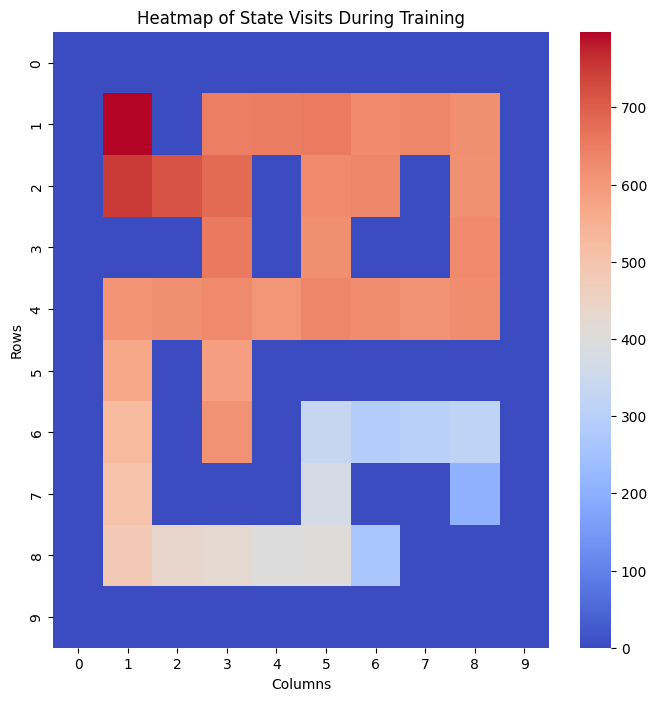

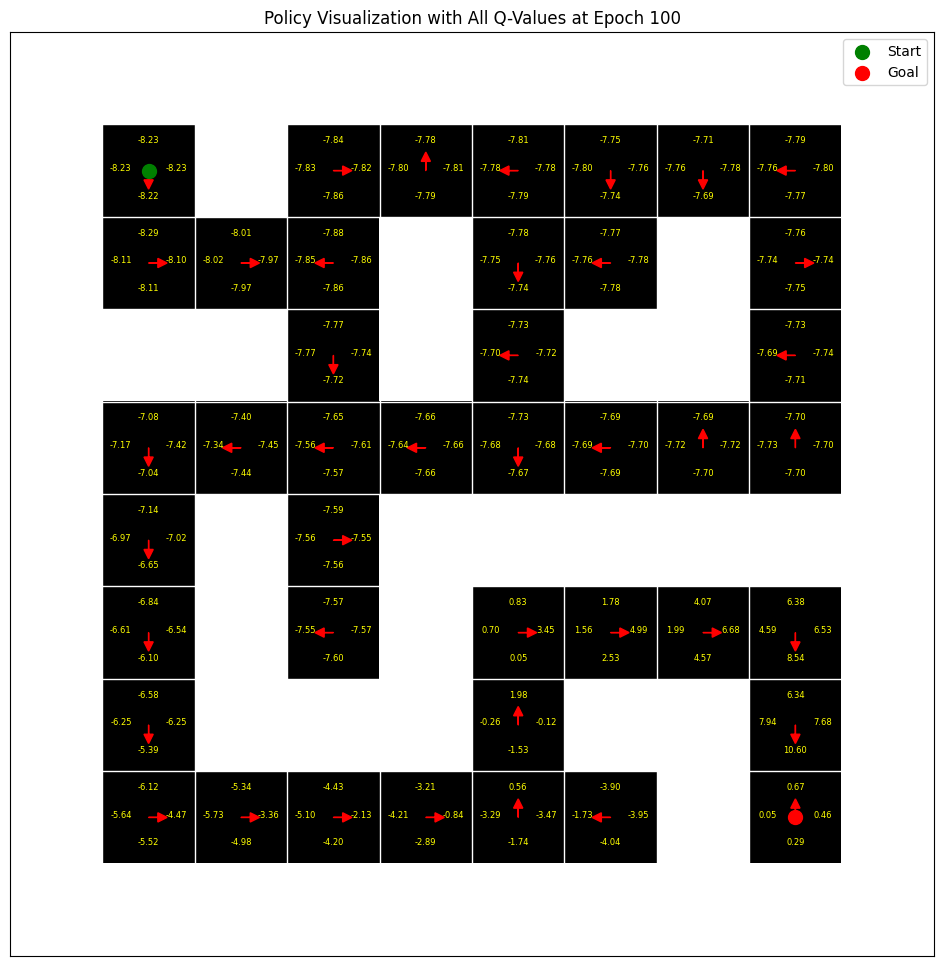

Training Progress:  39%|███▊      | 193/500 [00:01<00:01, 161.31it/s]


--- Metrics at Epoch 200 ---
Total Rewards: -49
Average Q-Value: -2.01
Exploration Actions: 17151
Exploitation Actions: 11570
Total Steps in this Epoch: 60


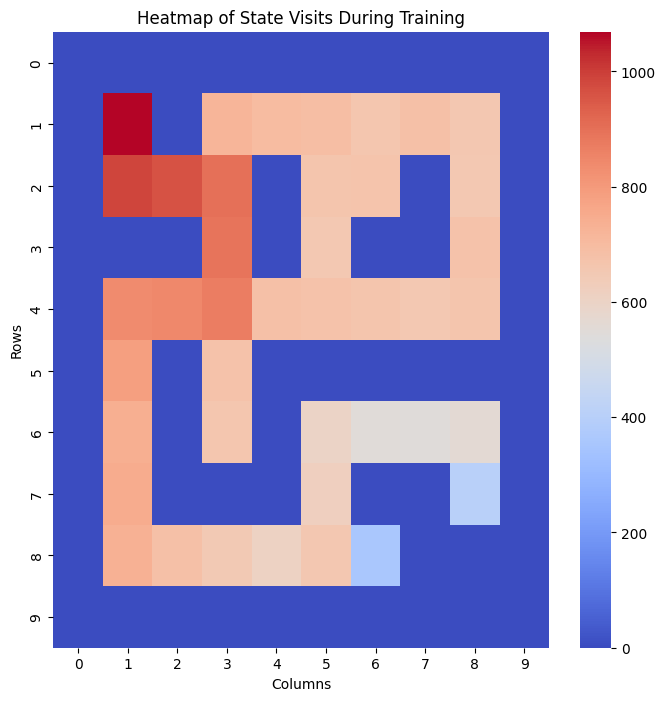

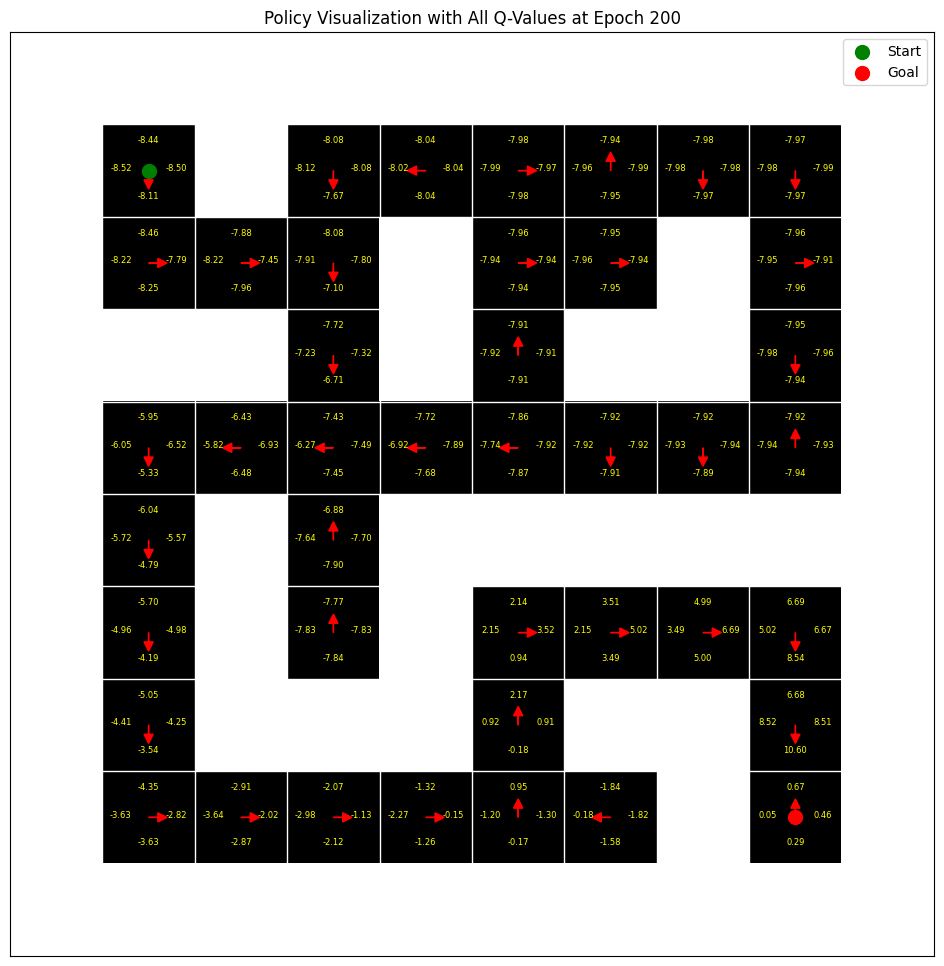

Training Progress:  48%|████▊     | 239/500 [00:02<00:02, 96.23it/s] 


--- Metrics at Epoch 300 ---
Total Rewards: -29
Average Q-Value: -1.96
Exploration Actions: 20448
Exploitation Actions: 13981
Total Steps in this Epoch: 40


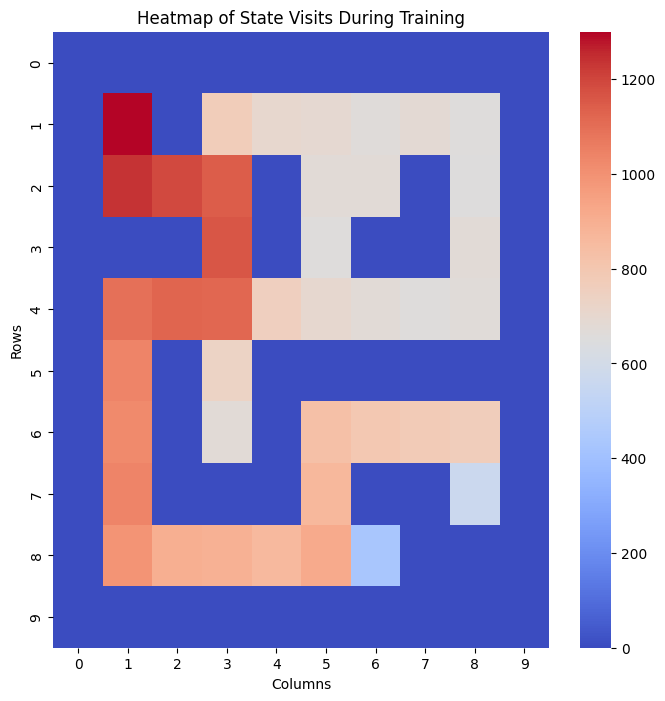

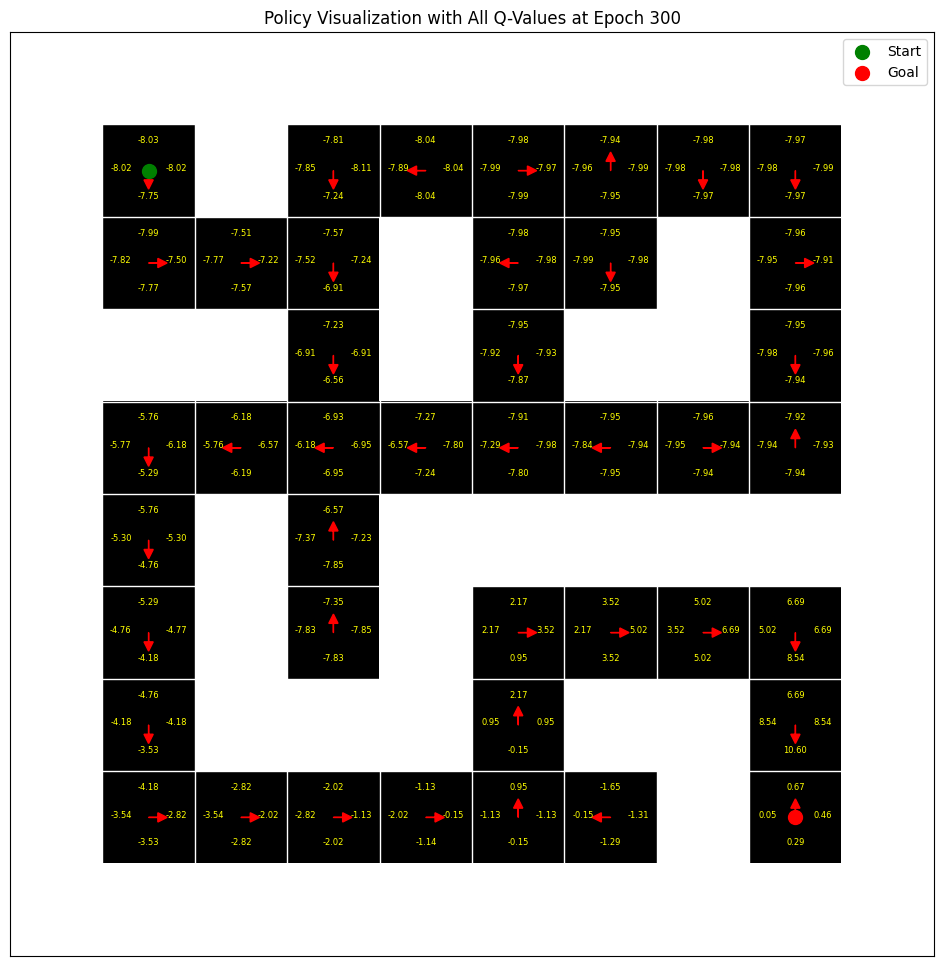

Training Progress:  60%|██████    | 300/500 [00:03<00:02, 82.80it/s]


--- Metrics at Epoch 400 ---
Total Rewards: -67
Average Q-Value: -1.95
Exploration Actions: 23915
Exploitation Actions: 16317
Total Steps in this Epoch: 78


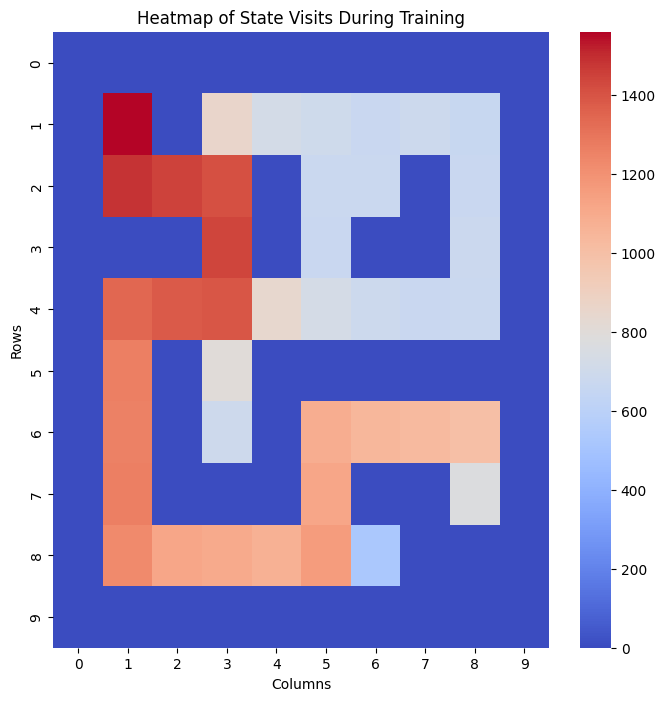

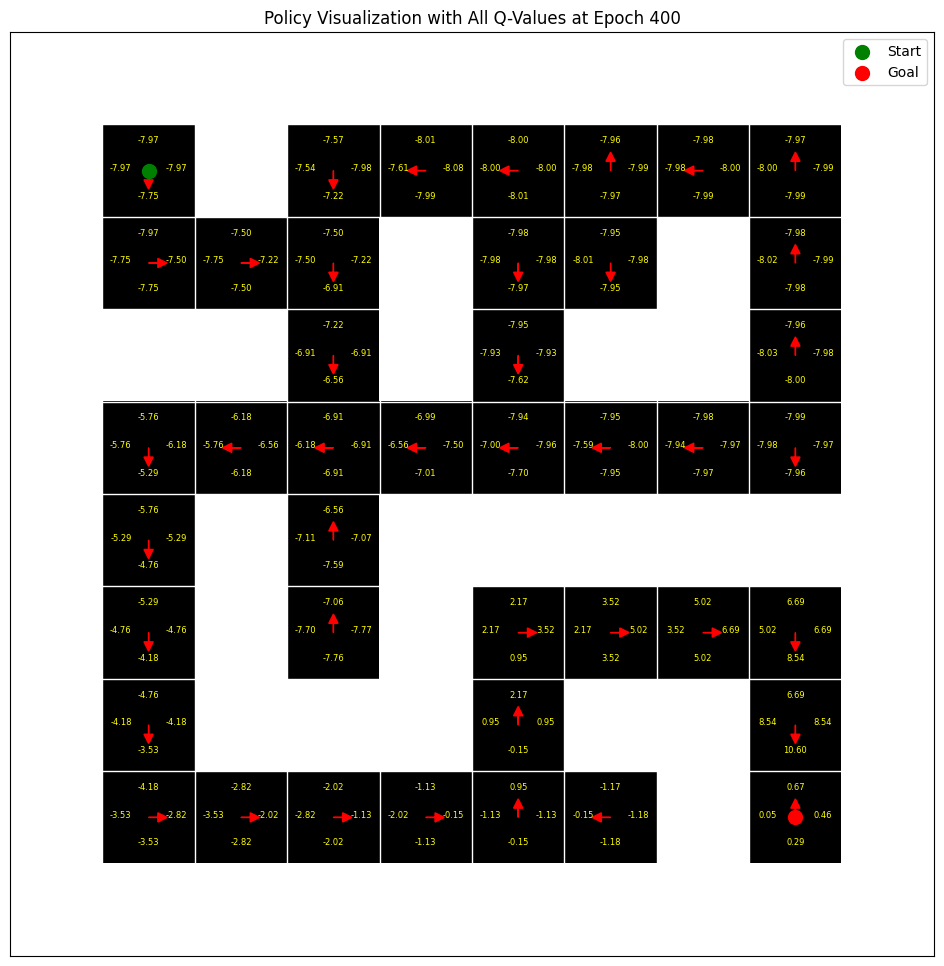

Training Progress:  80%|████████  | 400/500 [00:04<00:01, 90.12it/s]


--- Metrics at Epoch 500 ---
Total Rewards: -32
Average Q-Value: -1.94
Exploration Actions: 27425
Exploitation Actions: 18536
Total Steps in this Epoch: 43


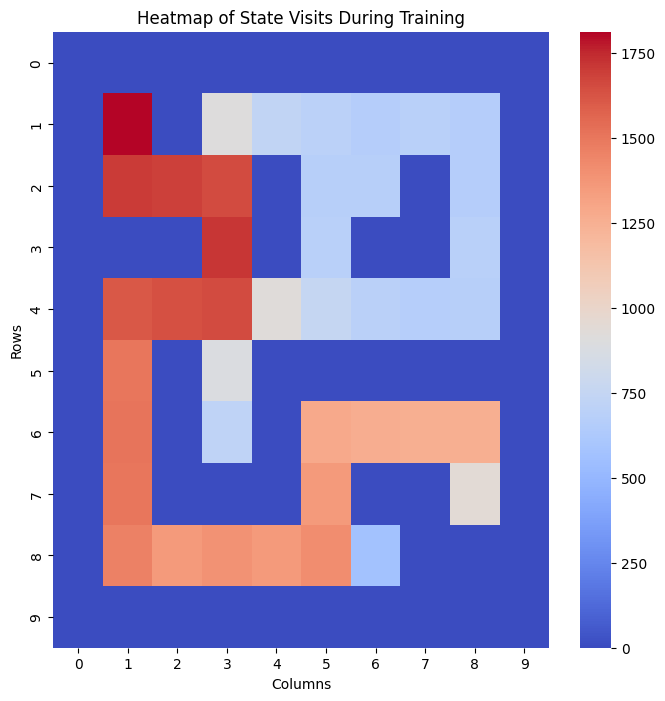

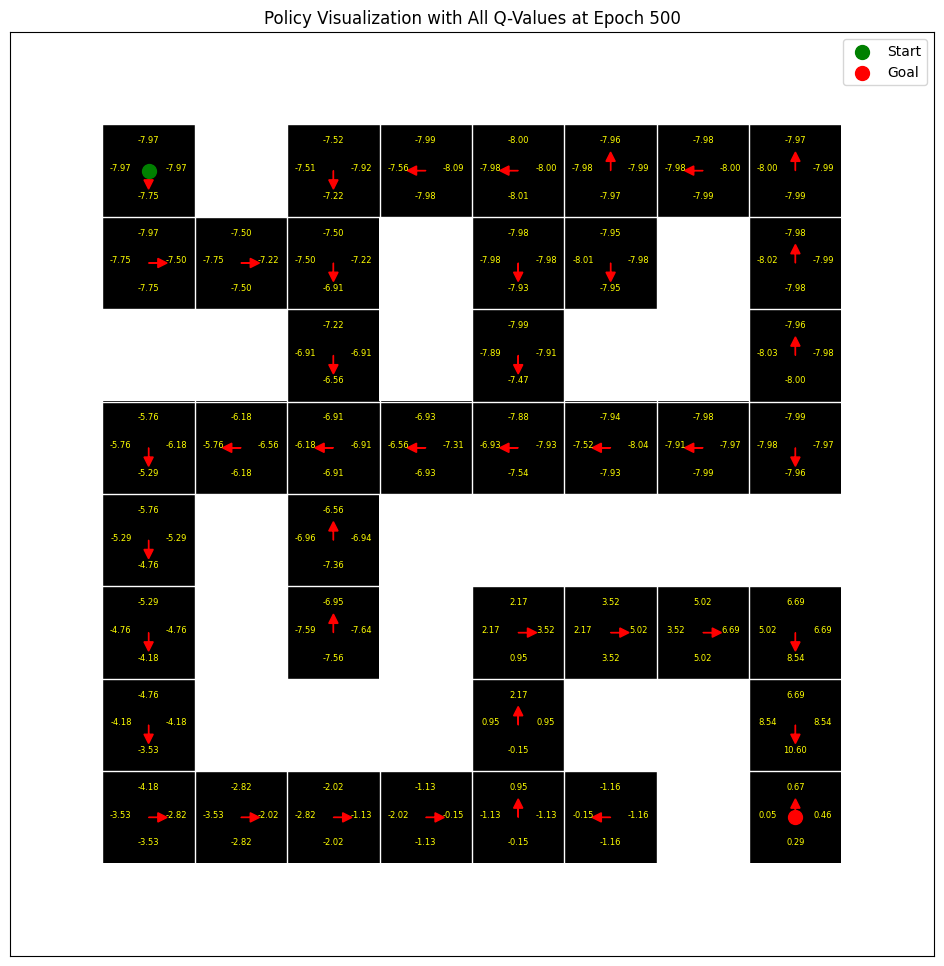

Training Progress: 100%|██████████| 500/500 [00:05<00:00, 97.16it/s]


In [12]:
# Train the agent and display the policy with Q-values
train_agent()